# Final Project: House Price Prediction 

## Corpus Christi Team 

## Step 5 (Machine Learning Model for House Predictions)

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import requests
import urllib.request
import seaborn as sns

from pathlib import Path
from matplotlib import pyplot as plt
from sklearn.datasets import make_blobs
from sklearn import metrics
from xgboost import plot_importance
from sklearn.tree import plot_tree
from sklearn import tree
from xgboost import plot_importance


from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV


from shapash.explainer.smart_explainer import SmartExplainer

import re
import os
import glob
from datetime import datetime as dt
import warnings
from time import sleep
from tqdm import tqdm

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# Read the CSV and do Basic Cleaning 


In [4]:
# https://github.com/Hecgithub/House_Price_Prediction/blob/03_Data_Gathering_and_Cleaning/03_Code_and_Data/03_Data_Cleaning/data/05_Raw_from_DB_htx_joined_data_house_crime.csv

columns = [
    "price", "bedrooms", "bathrooms", "constructedarea", "zipcode", "yearbuilt", "lotareasqft", 
    "avgschoolrating", "avgschooldist", "crimepercentage" 
]

target = ["price"]

In [5]:
# reading in the data set from the github 
url = 'https://raw.githubusercontent.com/Hecgithub/House_Price_Prediction/main/03_Code_and_Data/05_ML_Model/data/05_ML_from_DB_htx_joined_data_house_crime.csv'

urllib.request.urlretrieve(url, '05_ML_from_DB_htx_joined_data_house_crime.csv')

('05_ML_from_DB_htx_joined_data_house_crime.csv',
 <http.client.HTTPMessage at 0x1dd9c4b93c8>)

In [6]:
# There are 25 columns and 4499 rows 
df = pd.read_csv('05_ML_from_DB_htx_joined_data_house_crime.csv')
print(df.shape)

(3936, 10)


In [7]:
# Peek at the dateset
df.head()

,price,bedrooms,bathrooms,constructedarea,zipcode,yearbuilt,lotareasqft,avgschoolrating,avgschooldist,crimepercentage
0,276000,3,2,3612.0,77489,1971,8764.272,4.0,0.966667,0.336866
1,220000,3,2,1270.0,77489,1972,7884.360,4.0,0.866667,0.336866
2,230000,4,2,1765.0,77489,1974,7148.196,4.0,0.633333,0.336866
3,225000,3,2,1444.0,77489,1978,7731.900,4.0,0.833333,0.336866
4,246500,3,2,1738.0,77489,1978,8062.956,4.0,0.633333,0.336866


In [8]:
# Checking the features of the data set
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3936 entries, 0 to 3935
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   price            3936 non-null   int64  
 1   bedrooms         3936 non-null   int64  
 2   bathrooms        3936 non-null   int64  
 3   constructedarea  3936 non-null   float64
 4   zipcode          3936 non-null   int64  
 5   yearbuilt        3936 non-null   int64  
 6   lotareasqft      3936 non-null   float64
 7   avgschoolrating  3936 non-null   float64
 8   avgschooldist    3936 non-null   float64
 9   crimepercentage  3936 non-null   float64
dtypes: float64(5), int64(5)
memory usage: 307.6 KB


In [9]:
# Get statistics
df.describe()

,price,bedrooms,bathrooms,constructedarea,zipcode,yearbuilt,lotareasqft,avgschoolrating,avgschooldist,crimepercentage
count,3936.000000,3936.000000,3936.000000,3936.000000,3936.000000,3936.000000,3936.000000,3936.000000,3936.000000,3936.000000
mean,392306.922510,3.356199,2.836636,2098.207488,77068.014990,1996.267785,5798.572866,4.603913,1.358062,1.038065
std,149782.881299,0.674571,0.849539,628.152209,78.692163,28.197613,2449.275745,1.368877,0.627053,0.695450
min,200000.000000,0.000000,0.000000,480.000000,77003.000000,1920.000000,1240.000000,2.000000,0.166667,0.000435
25%,277033.000000,3.000000,2.000000,1665.000000,77021.000000,1975.000000,3598.056000,4.000000,0.933333,0.356886
50%,359900.000000,3.000000,3.000000,1982.500000,77055.000000,2006.000000,6381.540000,4.000000,1.300000,1.189911
75%,454325.000000,4.000000,3.000000,2455.000000,77083.000000,2022.000000,7775.701340,6.000000,1.633333,1.481514
max,900000.000000,8.000000,7.000000,6000.000000,77598.000000,2023.000000,9997.020000,9.000000,5.100000,3.719017


<AxesSubplot:>

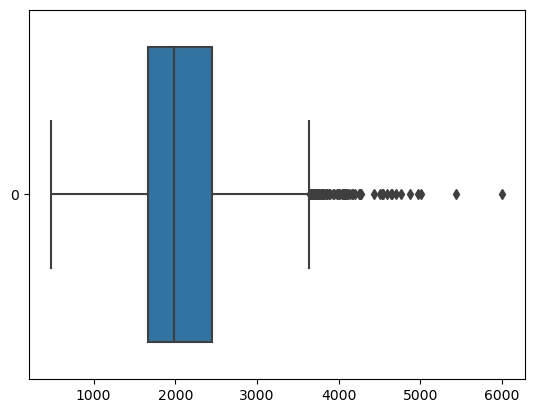

In [10]:
# Evaluate outliers with boxplot
sns.boxplot(df['constructedarea'], orient="h")

In [11]:
# Position of the Outlier
print(np.where(df['constructedarea']>10))

(array([   0,    1,    2, ..., 3933, 3934, 3935], dtype=int64),)


In [12]:
##''' Detection '''
# IQR
Q1 = np.percentile(df['constructedarea'], 25,
                   interpolation = 'midpoint')
 
Q3 = np.percentile(df['constructedarea'], 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1
 
print("Old Shape: ", df.shape)
 
# Upper bound
upper = np.where(df['constructedarea'] >= (Q3+1.5*IQR))
# Lower bound
lower = np.where(df['constructedarea'] <= (Q1-1.5*IQR))
 
##''' Removing the Outliers '''
df.drop(upper[0], inplace = True)
df.drop(lower[0], inplace = True)
 
print("New Shape: ", df.shape)

Old Shape:  (3936, 10)
New Shape:  (3857, 10)


In [13]:
# Reaplce all null values by the average of the column values
df = df.fillna(df.mean())

In [14]:
# Find columns with missing values and their percent missing
df.isnull().sum()                                                     
miss_val = df.isnull().sum().sort_values(ascending=False)
miss_val = pd.DataFrame(data=df.isnull().sum().sort_values(ascending=False), columns=['MissvalCount'])
miss_val


,MissvalCount
price,0
bedrooms,0
bathrooms,0
constructedarea,0
zipcode,0
yearbuilt,0
lotareasqft,0
avgschoolrating,0
avgschooldist,0
crimepercentage,0


In [15]:
# drop rows with any missing values
df.dropna(inplace=True)

In [16]:
# Check the dimension of the dataset
df.shape

(3857, 10)

Data set is has 10 features and 4500 observations 

# Explore Data

<AxesSubplot:>

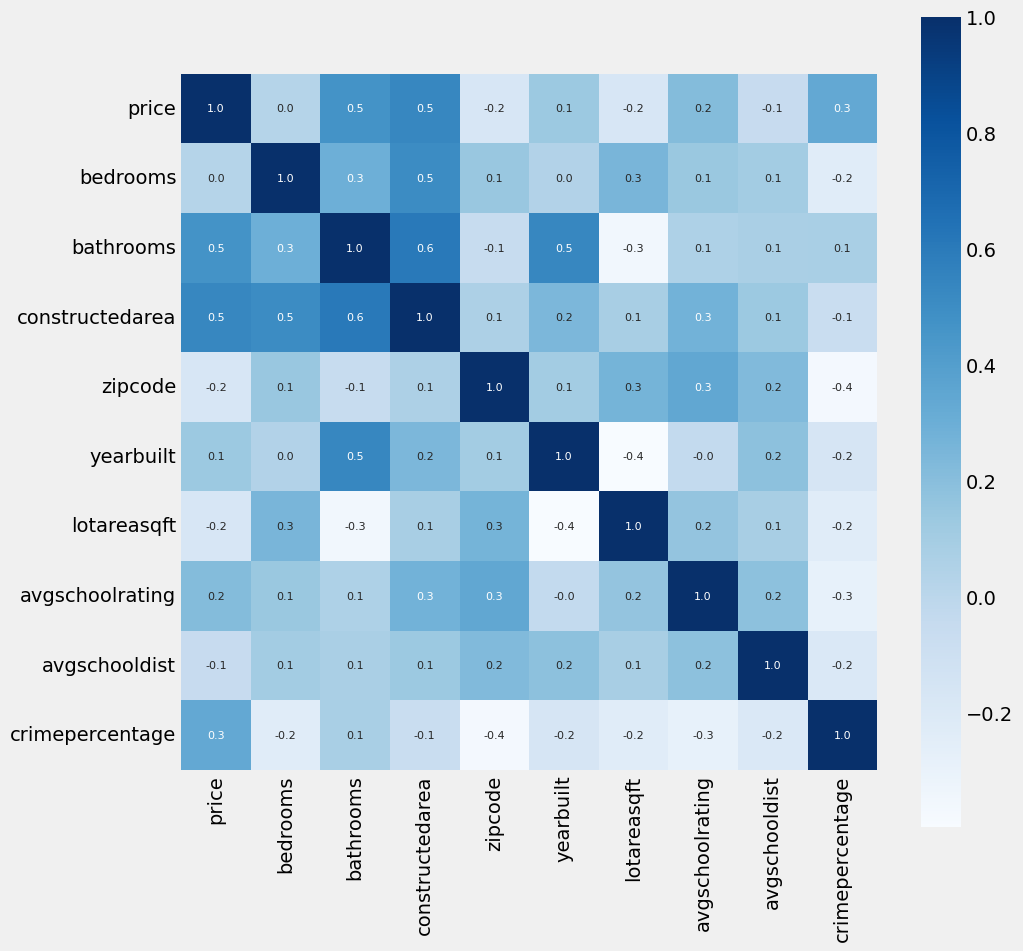

In [17]:
# Heat map
# A heat map shows the correlation between the input data columns
# There are 2 types of correlation:
# Positive: As the magnitude of a feature increases, the magnitude of a correlated feature increases
# Negative: As the magnitude of a feature increases, the magnitude of a correlated feature decreases
correlation = df.corr()
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10,10))
sns.heatmap(correlation, cbar=True, square=True, fmt='.1f', annot=True, annot_kws={'size':8}, cmap='Blues')

<AxesSubplot:xlabel='price', ylabel='Density'>

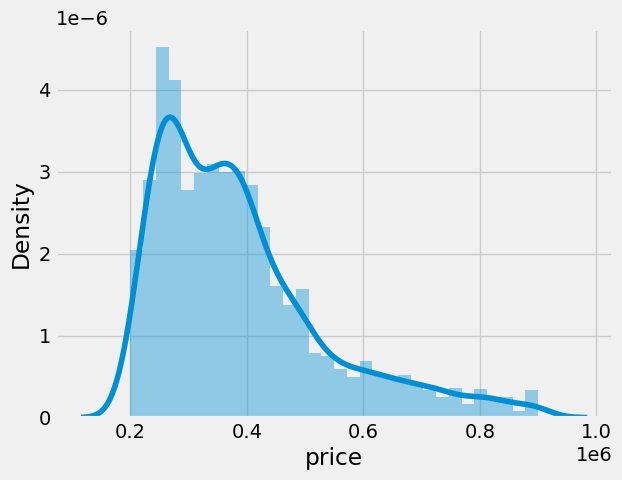

In [18]:
# Check distribution of target variable which is Price
sns.distplot(df.price)

The Price distribution is slightly skewed to the right. 

In [19]:
# Review the skewness of each feature
df.skew().sort_values(ascending=False)

zipcode            3.210708
price              1.280632
avgschooldist      1.206939
avgschoolrating    0.694355
bedrooms           0.647339
constructedarea    0.467394
crimepercentage    0.177603
bathrooms          0.067269
lotareasqft       -0.349182
yearbuilt         -0.752215
dtype: float64

Values that are closer to zero are less skewed. 

# Train- Test Split dataset


In [20]:
# Get the features and the target column 
# X = Features, y = target
X = df.drop('price', axis=1)
y = df[["price"]]

In [21]:
# split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2)
print(X.shape, X_train.shape, X_test.shape)

(3857, 9) (3085, 9) (772, 9)


Spliting the data set, will use random sampling with 80/20 train-test split. This means that 80% of the data will be used for training and 20% will be used for testing. Idealy this is a good ratios based on the data set that we are using. 


# Modeling

## Linear Regression 

Linear Regression is a Machine Learning algorithm based on supervised learning. It preforms a regression task. Regression models a target prediction value based on independent variables. This model is highly used for finding out the relationship between variables and forecasting. 

In [22]:
lr = LinearRegression()
# fit optimal linear regression line on training data, this performs gradient descent under the hood
lr.fit(X_train, y_train)

LinearRegression()

In [23]:
# given our model and our fit, predict y_values using X_test set
yr_hat = lr.predict(X_test)

In [24]:
# evaluate the algorithm with a test set 
lr_score = lr.score(X_test, y_test)  # train test 
print("Accuracy: ", lr_score)

Accuracy:  0.5197638091787441


In [25]:
# cross validation to find 'validate' score across multiple samples, automatically does Kfold stratifying
lr_cv = cross_val_score(lr, X, y, cv = 5, scoring= 'r2')
print("Cross-validation results: ", lr_cv)
print("R2: ", lr_cv.mean())

Cross-validation results:  [0.08142212 0.16506784 0.47008777 0.62863632 0.51880346]
R2:  0.37280350303794585


<function matplotlib.pyplot.show(close=None, block=None)>

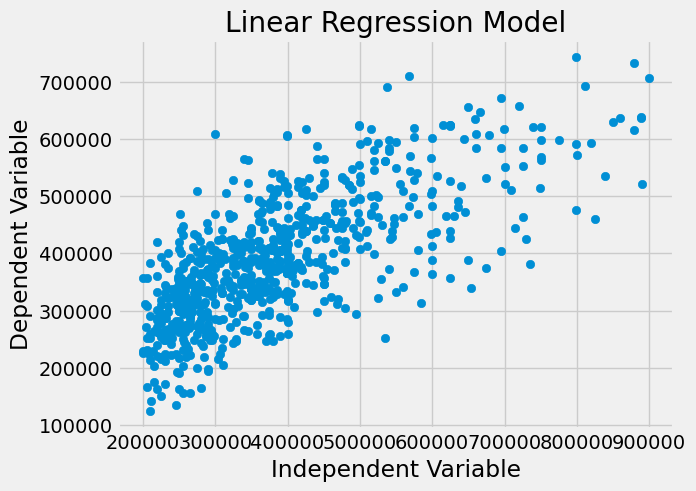

In [26]:
# Create the scatter plot
plt.scatter(y_test, yr_hat)

# Add a title
plt.title('Linear Regression Model')

# Add x and y axis labels
plt.xlabel('Independent Variable')
plt.ylabel('Dependent Variable')

# Show the plot
plt.show


This model is showing a 51% accuracy of prediction for house prices in Huston Texas. 

## Random Forest

Random Forest is a Supervised Machine learning Algorithm tha is used widely in Classification and Regression problem. It builds decision trees on different samples and takes their majority vote for classification and average in case of regression. One of the most important features of the Random Forest Algorithm is that it can handle the data set containing continuous variables as in the case of regression and categorical variables as in the case of classification. It performs better results for classification problems.

In [122]:
#rfr = RandomForestRegressor(n_estimators = 100, max_depth = 5, min_samples_leaf= 5, max_features = 'sqrt')  # using GridSearch
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train) # gets the parameters for the rfr model
rfr_cv = cross_val_score(rfr,X, y, cv = 5, scoring = 'r2')
print("R2: ", rfr_cv.mean())

R2:  0.6788682628136289


In [26]:
# Random forest determined feature importances
rfr.feature_importances_

array([0.01558455, 0.02270332, 0.37424922, 0.1342285 , 0.06857054,
       0.05078573, 0.06357769, 0.04952203, 0.22077843])

INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsi

INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsi

INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsi

INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsi

INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsi

INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsi

INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsi

INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsi

INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsi

INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsi

INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsi

INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsi

INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsi

INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsi

INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsi

INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsi

INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsi

INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsi

INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsi

INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsi

INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsi

INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsi

INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsi

INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsi

INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsi

INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsi

INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsi

INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsi

INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsi

INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsi

INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsi

INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsi

INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsi

INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsi

INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsi

INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsi

INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsi

INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsi

INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsi

INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsi

INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsi

INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsi

INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsi

INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.08 < 1.0 pt not allowed by FreeType. Setting fontsi

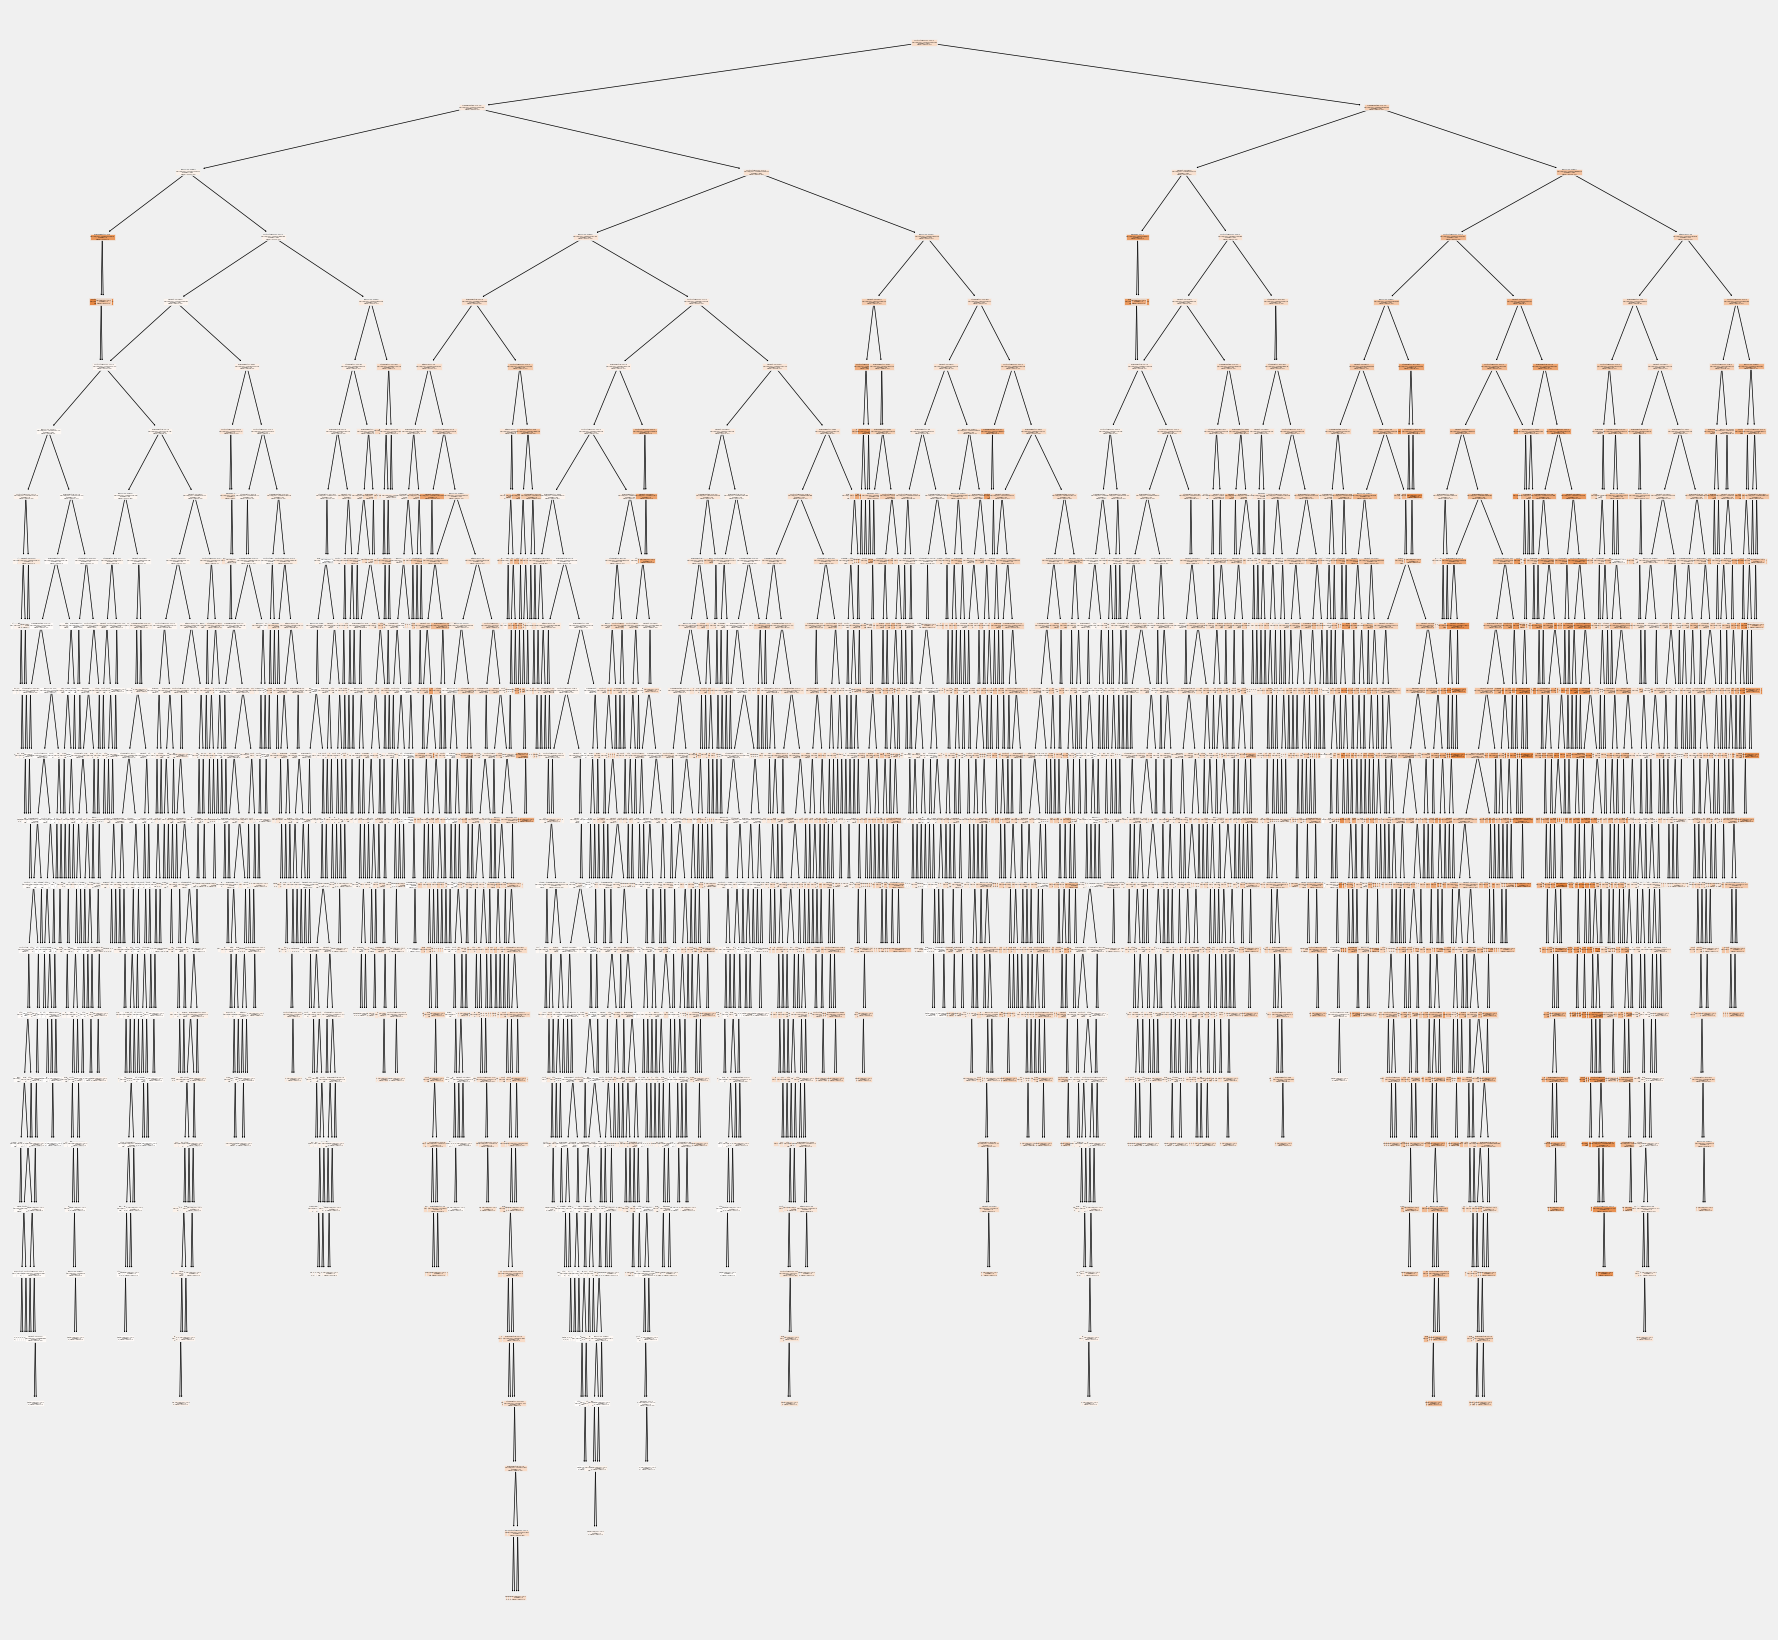

In [27]:
plt.figure(figsize=(20,20))
_ = tree.plot_tree(rfr.estimators_[0], feature_names=X.columns, filled=True)

This model is showing a 67% accuracy of prediction for house prices in Huston Texas. 

## XGBRegressor

The XGBRegressor is a supervised machine learning algorithm. It is used for regression problems, where the goal is to predict a continuous value, given a set of features.The algorithm learns to make predictions for new, unseen data by finding patterns in the training data that map inputs to the corresponding outputs.

In [27]:
# Load the model (XGBoost Regressor)
model = XGBRegressor()

# Train the model with the training data
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [28]:
y_pred = model.predict(X_test)

# Calculate the R squared error
error_r2 = metrics.r2_score(y_test, y_pred)

# Calculate the mean absolute error
error_ma = metrics.mean_absolute_error(y_test, y_pred)

print(f'R squared error: {error_r2} (should be close to 1)')

R squared error: 0.8009552751142148 (should be close to 1)


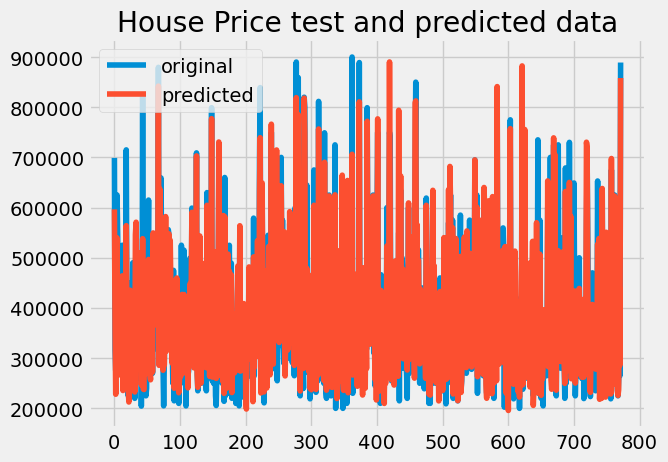

In [29]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("House Price test and predicted data")
plt.legend()
plt.show()

This model is the highest performing model and has an 80% accuracy for predicting house prices in the Huston Texas. 

## Plotting Feature Importance 

In [30]:
# Display the actual price vs the predicted price
y_test_df = y_test.reset_index(drop=True)
y_test_df = y_test_df.rename(columns = {'Price':'Actual_Price'})

y_pred_df = pd.DataFrame(y_pred, columns = ['Predicted_Price'])
y_pred_df = y_pred_df['Predicted_Price'].apply(np.ceil).astype('int')

# Display the actual and the predicted prices side by side
df_prices = pd.concat([y_test_df, y_pred_df], axis=1)
df_prices

,price,Predicted_Price
0,699000,596481
1,317000,357722
2,274999,228114
3,519900,462180
4,625000,539615
...,...,...
767,225000,225665
768,256000,236594
769,389900,441729
770,264900,286063


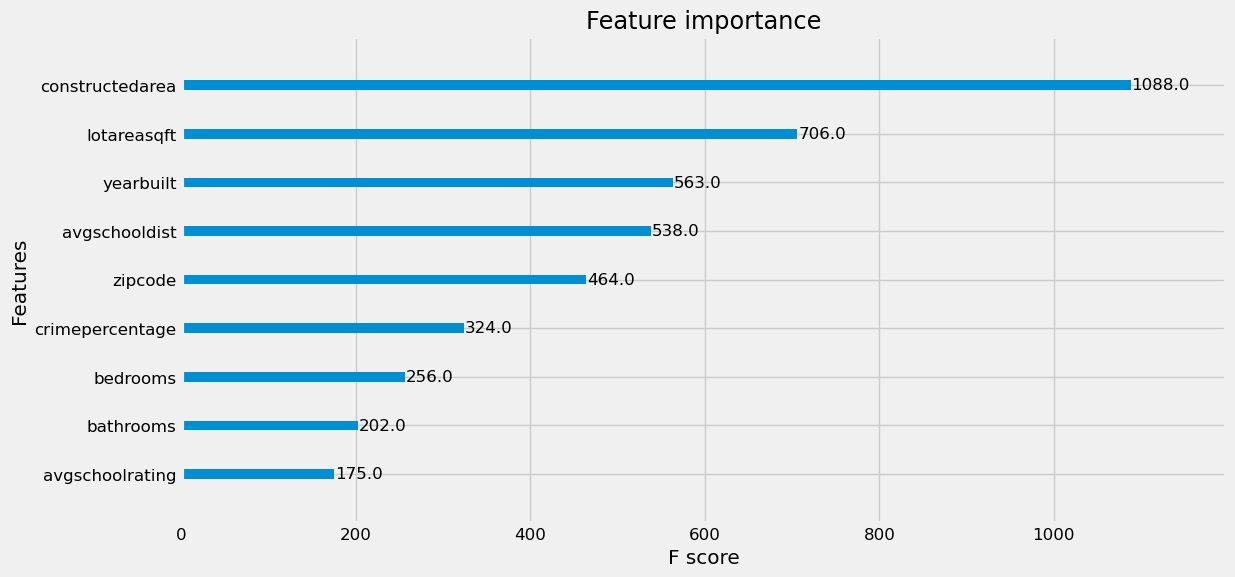

In [31]:
# Plot the features importance
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(figsize=(12,6))
plot_importance(model, ax=ax)
plt.show();

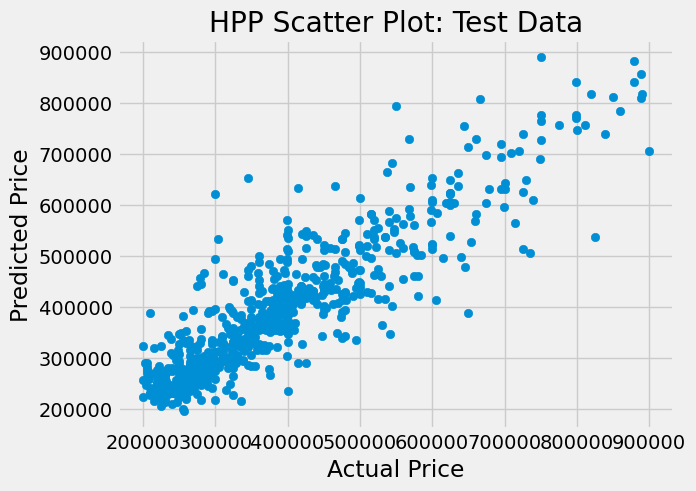

In [125]:
# Scatter Plot using test data
plt.scatter(y_test_df, y_pred_df)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('HPP Scatter Plot: Test Data')
plt.show()

## Understanding the model with Shapash

### If not installed, run the following command in your conda environment
!pip install shapash

In [33]:
# Initialize shapash with the ML model
xpl = SmartExplainer(model)

In [34]:
# Condition X_test and y_pred for Shapash
# Display the actual price vs the predicted price
temp = X_test.reset_index(drop=True)
sp_X_test = temp.rename(columns = {'Price':'Price'})
del(temp)

temp = pd.DataFrame(y_pred, columns = ['Price'])
sp_y_pred = temp['Price'].apply(np.ceil).astype('int')
del(temp)

temp = y_test.reset_index(drop=True)
sp_y_target = temp.rename(columns = {'Price':'Price'})
del(temp)

In [35]:
# Compile shapash
xpl.compile(x=sp_X_test, y_pred=sp_y_pred, y_target=sp_y_target)

In [36]:
app = xpl.run_app(title_story='House_Price_Prediction')

Dash is running on http://0.0.0.0:8050/



INFO:root:Your Shapash application run on http://LAPTOP-AIQ1UT08:8050/
INFO:shapash.webapp.smart_app:Dash is running on http://0.0.0.0:8050/

INFO:root:Use the method .kill() to down your app.


 * Serving Flask app 'shapash.webapp.smart_app' (lazy loading)
 * Environment: production


In [37]:
# Plot a summary with the contribution of the features.
summary_df = xpl.to_pandas(max_contrib=14) #Number of max features to show in summary
summary_df.head()

   Use a production WSGI server instead.
 * Debug mode: off


INFO:werkzeug: * Running on http://192.168.1.227:8050/ (Press CTRL+C to quit)


,Price,feature_1,value_1,contribution_1,feature_2,value_2,contribution_2,feature_3,value_3,contribution_3,feature_4,value_4,contribution_4,feature_5,value_5,contribution_5,feature_6,value_6,contribution_6,feature_7,value_7,contribution_7,feature_8,value_8,contribution_8,feature_9,value_9,contribution_9
0,596481,constructedarea,2623.0,96748.484375,zipcode,77004.0,74943.554688,crimepercentage,2.457729,58362.984375,lotareasqft,2304.0,-34108.324219,bathrooms,4.0,15649.797852,avgschoolrating,4.0,-15358.453125,bedrooms,3.0,8865.770508,avgschooldist,1.3,3929.836182,yearbuilt,2014.0,-1694.533325
1,357722,constructedarea,1726.0,-49534.742188,yearbuilt,2022.0,38436.28125,zipcode,77088.0,-32142.332031,avgschooldist,0.466667,22845.0,avgschoolrating,4.0,-6711.522461,crimepercentage,1.378365,-4685.560059,bedrooms,3.0,2318.771484,bathrooms,2.0,-1874.873657,lotareasqft,5784.768,-70.998886
2,228114,crimepercentage,0.009575,-55909.90625,zipcode,77073.0,-31556.494141,constructedarea,1983.0,-19158.820312,avgschoolrating,4.0,-15115.118164,yearbuilt,2013.0,-15020.445312,lotareasqft,2975.148,-14413.928711,avgschooldist,1.3,-4745.300781,bedrooms,4.0,-4082.544189,bathrooms,3.0,-1025.675293
3,462180,constructedarea,3067.0,128105.507812,crimepercentage,0.382565,-92050.28125,zipcode,77041.0,28334.470703,lotareasqft,9099.684,23841.34375,avgschoolrating,5.0,-14841.705078,bathrooms,4.0,13724.109375,yearbuilt,1999.0,-12656.862305,bedrooms,4.0,-4734.021973,avgschooldist,1.933333,3315.358154
4,539615,zipcode,77008.0,155868.828125,constructedarea,1483.0,-74913.15625,crimepercentage,1.325702,29308.974609,lotareasqft,4599.936,16944.146484,avgschoolrating,5.0,13275.957031,avgschooldist,0.8,10373.498047,bedrooms,3.0,2674.908447,bathrooms,2.0,-1710.342163,yearbuilt,1998.0,-1350.286987


In [38]:
# Kill the dashboard (Run when done)
#app.kill